In [1]:
import numpy as np
from matplotlib import pyplot as plt
from QUBO import QMatrix, QUBOSolution
from qutip import *
import networkx as nx
import dwave_networkx as dnx
import itertools
import minorminer as mm
from scipy import interpolate
from itertools import combinations
from collections import defaultdict
from graphs import DrawSolution, NetworkToFile, FileToNetwork
from graphs import DrawNetwork, GraphPartitioning, RandomGraphGenerator

In [68]:
def nextState(state):
    '''
    Modifies a given QUBO state into a new one
    
    Parameters
    ----------
    state  : array
             state of the QUBO Hamiltonian
    '''
    
    n = len(state) - 1
    aux = False
    
    while not (aux):
        
        if (state[n] == 0):
            aux = True
            break
        
        n -= 1
        if (n < 0):
            break
    
    state[n] = 1
    n += 1
    while (n < len(state)):
        state[n] = 0
        n +=1

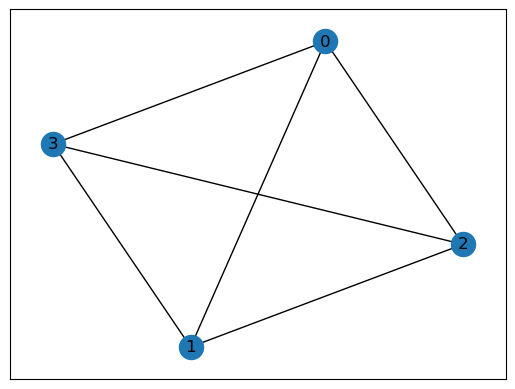

In [30]:
#Create the graph
G = FileToNetwork("graph3.txt")
DrawNetwork(G, "3.png")
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)
alpha = 1.25
beta=1
RCS = 0.2

In [21]:
#Embedding
C = FileToNetwork("chimera.txt")
#embedding = mm.find_embedding(G, C)
embedding = {0: [856], 1: [861], 2: [859, 863], 3: [858, 860]}
num_physical_qubits = 0
for i in range(len(embedding)):
    num_physical_qubits += len(embedding[i])
print(num_physical_qubits)

6


In [41]:
#Qubits used in physical system (physical graph)
physical_nodes = []
for vertex in embedding:
    for node in embedding[vertex]:
        physical_nodes.append(node)
num_physical_qubits = len(physical_nodes)
    
used_graph = C.subgraph(physical_nodes)   
    

#Logical parameters
Q = np.zeros((n,n))

for u, v in G.edges:
    node_u = min(u,v)
    node_v = max(u,v)
    
    Q[node_u,node_u] += 1*beta
    Q[node_v,node_v] += 1*beta
    Q[node_u,node_v] += -2*beta
 
for i in G.nodes:
    Q[i,i] += alpha*(1-n)

for i, j in combinations(G.nodes, 2):
    node_i = min(i,j)
    node_j = max(i,j)
    Q[node_i,node_j] += 2*alpha
    
    
#Physical parameters
Qp = defaultdict(int)
    
for i in G.nodes:
    chain_length = float(len(embedding[i]))
    for node in embedding[i]:
        Qp[(node, node)] = Q[i,i]/chain_length
        
for i in G.nodes:
    for j in range(i):
        number_of_connections = 0
        for node_i in embedding[i]:
            for node_j in used_graph.neighbors(node_i):
                if node_j in embedding[j]:
                    number_of_connections +=1
        for node_i in embedding[i]:
            for node_j in used_graph.neighbors(node_i):
                if  node_j in embedding[j]:
                    u =  min(node_i, node_j)
                    v =  max(node_i, node_j)
                    Qp[(u,v)] = Q[j,i]/number_of_connections   
        
max_val = np.abs(np.amax(Q))
min_val = np.abs(np.amin(Q)) 
chain_strength = max(max_val, min_val)*RCS
    
for i in G.nodes:
    chain = used_graph.subgraph(embedding[i])
    chain_edges = list(chain.edges)
    for edge in chain_edges:
        u =  min(edge)
        v =  max(edge)
        
        Qp[(u,v)] = -chain_strength
        #Qp[(u,u)] +=  chain_strength/2
        #Qp[(v,v)] +=  chain_strength/2
    
Qp_matrix = np.zeros((num_physical_qubits, num_physical_qubits))
for label1, label2 in Qp:
    i = physical_nodes.index(label1)
    j = physical_nodes.index(label2)
    node1 = min(i,j)
    node2 = max(i,j)
        
    Qp_matrix[node1][node2] = Qp[(label1, label2)]

print(Qp_matrix)

[[-0.75   0.5    0.     0.5    0.     0.5  ]
 [ 0.    -0.75   0.5    0.     0.5    0.   ]
 [ 0.     0.    -0.375 -0.15   0.     0.25 ]
 [ 0.     0.     0.    -0.375  0.25   0.   ]
 [ 0.     0.     0.     0.    -0.375 -0.15 ]
 [ 0.     0.     0.     0.     0.    -0.375]]


In [42]:
#Preparing all possible vectors
x = itertools.product([0,1], repeat = 6)
list_x = list(x)
    
   
    
#Finding the solution
sol = np.zeros(len(list_x))
aux = 0
for i in range(len(list_x)):
    aux = np.matmul(list_x[i], Qp_matrix)
    sol[i] = np.matmul(aux, list_x[i])
    
E = np.amin(sol)
min_list = np.isclose(sol, E, atol = 1e-2)
        
xmin = []
gap = []
i = 0
for item in min_list:
    if item == True:
        xmin.append(list_x[i])
    else:
        gap.append(sol[i])
    i += 1
num_sols = len(xmin)
    
#Energy gap
E2 = np.amin(gap)
Egap = E2-E

In [43]:
print(num_sols)
print(xmin)

2
[(0, 1, 0, 1, 0, 1), (1, 0, 1, 0, 1, 0)]


In [45]:
{(861, 856): 0.5, (858, 861): 0.5, (860, 856): 0.5, (860, 858): -1.5, (859, 861): 0.5, (859, 860): 0.25, (863, 856): 0.5, (863, 858): 0.25, (863, 859): -1.5, (856, 856): -0.75, (861, 861): -0.75, (858, 858): 0.375, (860, 860): 0.375, (859, 859): 0.375, (863, 863): 0.375}

{(861, 856): 0.5,
 (858, 861): 0.5,
 (860, 856): 0.5,
 (860, 858): -1.5,
 (859, 861): 0.5,
 (859, 860): 0.25,
 (863, 856): 0.5,
 (863, 858): 0.25,
 (863, 859): -1.5,
 (856, 856): -0.75,
 (861, 861): -0.75,
 (858, 858): 0.375,
 (860, 860): 0.375,
 (859, 859): 0.375,
 (863, 863): 0.375}

In [46]:
{(1777, 1783): -1.5, (1779, 1783): 0.5, (1781, 1777): 0.25, (1781, 1779): 0.5, (1776, 1783): 0.25, (1776, 1781): -1.5, (1780, 1777): 0.5, (1780, 1779): 0.5, (1780, 1776): 0.5, (1783, 1783): 0.375, (1777, 1777): 0.375, (1779, 1779): -0.75, (1781, 1781): 0.375, (1776, 1776): 0.375, (1780, 1780): -0.75}

{(1777, 1783): -1.5,
 (1779, 1783): 0.5,
 (1781, 1777): 0.25,
 (1781, 1779): 0.5,
 (1776, 1783): 0.25,
 (1776, 1781): -1.5,
 (1780, 1777): 0.5,
 (1780, 1779): 0.5,
 (1780, 1776): 0.5,
 (1783, 1783): 0.375,
 (1777, 1777): 0.375,
 (1779, 1779): -0.75,
 (1781, 1781): 0.375,
 (1776, 1776): 0.375,
 (1780, 1780): -0.75}

In [47]:
embedding = {1: [1779], 0: [1783, 1777], 3: [1781, 1776], 2: [1780]}

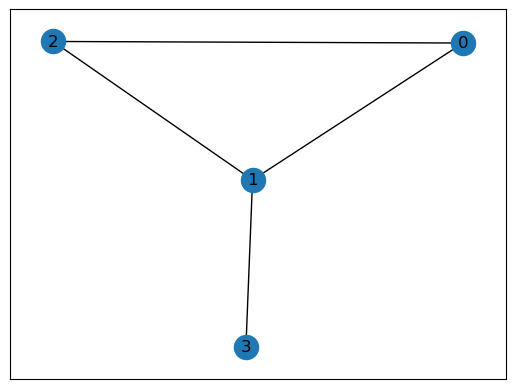

In [5]:
n=4
p=0.6
G = RandomGraphGenerator(n,p)
NetworkToFile(G, "graph4.txt")
DrawNetwork(G, "4.png")